In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from data.task_multi import multi
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import utils

In [91]:
class pool_encoder(nn.Module):
    def __init__(self):
        super(pool_encoder, self).__init__()
        self.embed = nn.Linear(2,2)
        self.l1 = nn.Linear(2, 100)
        self.l2 = nn.Linear(100,100)
        self.l3 = nn.Linear(100,30)
    def forward(self, x):
        output = self.embed(x)
        x1 = F.relu(self.l1(output))
        x2 = F.relu(self.l2(x1))
        x3 = self.l3(x2)
        return x3, output
    
class pool_decoder(nn.Module):
    def __init__(self):
        super(pool_decoder, self).__init__()
        self.l1 = nn.Linear(30, 100)
        self.l2 = nn.Linear(100,2)
    def forward(self, x):
        x1 = F.relu(self.l1(x))
        x2 = self.l2(x1)
        return x2  

In [92]:
encoder = pool_encoder()
decoder = pool_decoder()
encoder_optim = torch.optim.Adam(encoder.parameters(),lr=5e-4)
decoder_optim = torch.optim.Adam(decoder.parameters(),lr=5e-4)

In [93]:
task_family_train = multi()
task_family_test = multi()

In [89]:
encoder.train()
decoder.train()
loss = []
batch = 10

for task in range(300):
    train_inputs = []
    # sample tasks
    target_function = task_family_train.sample_tasks(batch)
    for t in range(batch):        
        x = task_family_train.sample_inputs(10)
        y = target_function[t](x)
        data = torch.cat([x,y],dim=1)# 10 * 2
        train_inputs.append(data)
    train_inputs = torch.stack(train_inputs,dim=0)# batch * 10 * 2
    #train_inputs = torch.cat(train_inputs,dim=0)
    embedding, target = encoder(train_inputs)
    train_outputs = decoder(embedding)
    # get targets
    train_targets = train_inputs

    task_loss = F.mse_loss(train_outputs, train_targets)

    task_loss.backward()
    encoder_optim.step()
    decoder_optim.step()
    loss.append(task_loss)


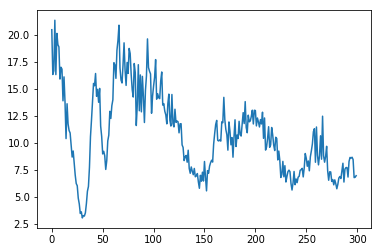

In [90]:
plt.plot(loss)
plt.show()

In [81]:
loss[-1]

tensor(0.8588, grad_fn=<MeanBackward0>)

In [65]:
#test
loss = 0
encoder.eval()
decoder.eval()
with torch.no_grad():
    for task in range(100):

        # sample tasks
        target_function = task_family_test.sample_task()
        x = task_family_test.sample_inputs(10)
        y = target_function(x)
        test_inputs = torch.cat([x,y],dim=1)
        #print(y)
        embedding = encoder(test_inputs)
        test_outputs = decoder(embedding)
        # get targets
        test_targets = test_inputs

        task_loss = F.mse_loss(train_outputs, train_targets)
        loss += task_loss/100

AttributeError: 'tuple' object has no attribute 'dim'

In [66]:
loss

0

In [67]:
loss = 0
type = []
embed = []
encoder.eval()
decoder.eval()
with torch.no_grad():
    for task in range(300):
        # sample tasks
        target_function,ty = task_family_test.sample_task(return_type=True)
        x = task_family_test.sample_inputs(10)
        y = target_function(x)
        test_inputs = torch.cat([x,y],dim=1)
        a,target = encoder(test_inputs)
        #embedding,_ = torch.max(a,dim=0)
        embedding = torch.mean(a,dim=0)
        #print(embedding.shape)
        type.append(ty)
        embed.append(embedding.numpy())

In [68]:
type = np.array(type)
em = np.stack(embed,axis=0)
em = TSNE(n_components=2).fit_transform(em)
y = em

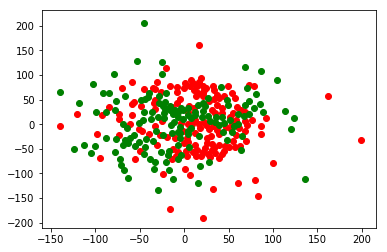

In [69]:
import matplotlib.pyplot as plt
plt.scatter(y[type==0][:,0],y[type==0][:,1],c='r')
plt.scatter(y[type==1][:,0],y[type==1][:,1],c='g')
plt.show()

In [56]:
import torch

In [127]:
class place(nn.Module):
    def __init__(self):
        super(place, self).__init__()
        self.l1 = nn.Linear(10, 40)
        self.l2 = nn.Linear(40, 40)
        self.l3 = nn.Linear(40, 30)
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        logits = self.l3(x)
        return logits

In [128]:
latent_dim = 15
categorical_dim = 2 
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -torch.log(-torch.log(U + eps) + eps)


def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)


def gumbel_softmax(logits, temperature, hard=False):
    """
    ST-gumple-softmax
    input: [*, n_class]
    return: flatten --> [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    
    if not hard:
        return y#y.view(-1, latent_dim * categorical_dim)

    shape = y.size()#10*10*10
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    # Set gradients w.r.t. y_hard gradients w.r.t. y
    y_hard = (y_hard - y).detach() + y
    return y_hard#y_hard.view(-1, latent_dim * categorical_dim)

In [143]:
p_encoder = place()
x = torch.randn([10])
logits = p_encoder(x)
logits = logits.reshape([latent_dim, categorical_dim])
#logits = torch.rand([1,2,2],requires_grad=True)
tem = 1
y = gumbel_softmax(logits,tem)

In [170]:
logits.shape

torch.Size([15, 2])

In [147]:
torch.norm(torch.zeros([2])+0.5,1)

tensor(0.7071)

In [158]:
a = torch.ones([15]) * 0.6
out = torch.bernoulli(a)
out

tensor([1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1.])

In [159]:
np.random.choice([1,2])

2

In [36]:
file = utils.load_obj('./multi_result_files/3b85757073744aadd281e4307f6739e3')

In [37]:
file.test_loss[-10:]

[1.5235464458540082,
 1.7569779579341411,
 2.588942586295307,
 1.9036784174572676,
 2.3612995272129775,
 2.823535210983828,
 1.8619225160777568,
 1.8504605675861239,
 2.2933800024818627,
 2.048745587319136]

In [22]:
from cavia_model_back import CaviaModel, pool_encoder, place
from data.task_multi import multi

In [2]:
logger = utils.load_obj('./multi_result_files/12d8a79ed53892a21408907e99e14b58')
encoder = logger.best_encoder_valid_model
p_encoder = logger.best_place_valid_model

In [3]:
utils.set_seed(123)
task_family_test = multi()

In [56]:
from gumbel_sample import gumbel_softmax

In [4]:
task_family = task_family_test
type = []
prob = []
for t in range(300):

    # sample a task
    target_function,ty = task_family.sample_task(True)

    # get data for current task
    curr_inputs = task_family.sample_inputs(10)
    curr_targets = target_function(curr_inputs)

    train_inputs = torch.cat([curr_inputs,curr_targets],dim=1)
    a = encoder(train_inputs)
    #embedding,_ = torch.max(a,dim=0)
    embedding = torch.mean(a,dim=0)
    #model.set_context_params(embedding)
    logits = p_encoder(embedding)
    logits = logits.reshape([2])
    y = F.softmax(logits, dim=-1)
    output = torch.argmax(y)
    #y = gumbel_softmax(logits, 0.3, hard=True)
    type.append(ty)
    prob.append(output.data.numpy())
    #print(qy[:,1],ty)

In [6]:
result = np.stack(prob,axis=0)

In [7]:
type = np.array(type)

In [60]:
model = TSNE(n_components=2, random_state=0)
y = model.fit_transform(result) 

In [61]:
type = np.array(type)

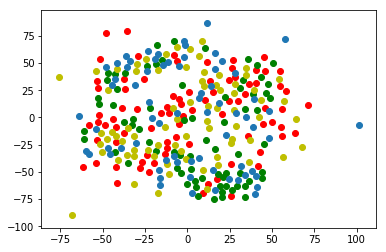

In [62]:
import matplotlib.pyplot as plt
plt.scatter(y[type==0][:,0],y[type==0][:,1],c='r')
plt.scatter(y[type==1][:,0],y[type==1][:,1],c='g')
plt.scatter(y[type==2][:,0],y[type==2][:,1],c='y')
plt.scatter(y[type==3][:,0],y[type==3][:,1])
plt.show()

In [ ]:
a = torch.rand([10,5,2])
b = torch.rand